# Association Rule Mining on Philippine Earthquake Clusters


## Import Libraries

In [35]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns


## Initial Data Exploration

In [16]:
df = pd.read_csv("../dataset/phivolcs_earthquake_data.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118955 entries, 0 to 118954
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Date_Time_PH       118955 non-null  object 
 1   Latitude           118931 non-null  float64
 2   Longitude          118931 non-null  float64
 3   Depth_In_Km        118954 non-null  object 
 4   Magnitude          118955 non-null  float64
 5   Location           118955 non-null  object 
 6   Specific_Location  118955 non-null  object 
 7   General_Location   118955 non-null  object 
dtypes: float64(3), object(5)
memory usage: 7.3+ MB


In [17]:
df.describe()

,Latitude,Longitude,Magnitude
count,118931.000000,118931.000000,118955.000000
mean,10.903026,124.056514,2.509793
std,3.977757,2.544317,0.701736
min,1.730000,10.560000,1.000000
25%,7.920000,121.420000,2.000000
50%,9.970000,124.870000,2.400000
75%,13.750000,126.270000,2.900000
max,24.840000,163.630000,7.500000


In [18]:
df.head()

,Date_Time_PH,Latitude,Longitude,Depth_In_Km,Magnitude,Location,Specific_Location,General_Location
0,2025-12-13 10:42:00,7.62,127.04,15.0,3.1,054 km N 85° E of Baganga (Davao Oriental),Baganga,Davao Oriental
1,2025-12-13 10:16:00,12.86,123.53,5.0,2.1,009 km S 56° W of Donsol (Sorsogon),Donsol,Sorsogon
2,2025-12-13 10:01:00,7.54,126.74,28.0,4.5,020 km S 79° E of Baganga (Davao Oriental),Baganga,Davao Oriental
3,2025-12-13 09:55:00,10.98,123.89,33.0,2.1,012 km S 52° W of City Of Bogo (Cebu),City Of Bogo,Cebu
4,2025-12-13 08:38:00,14.14,120.02,127.0,1.7,033 km N 20° W of Lubang (Occidental Mindoro),Lubang,Occidental Mindoro


## Initial Data Analysis

/var/folders/k4/7yxy_0xn1fx_1lbbp0f1jv800000gn/T/ipykernel_76140/4115350972.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_counts = df.set_index('Date_Time_PH').resample('M').size()


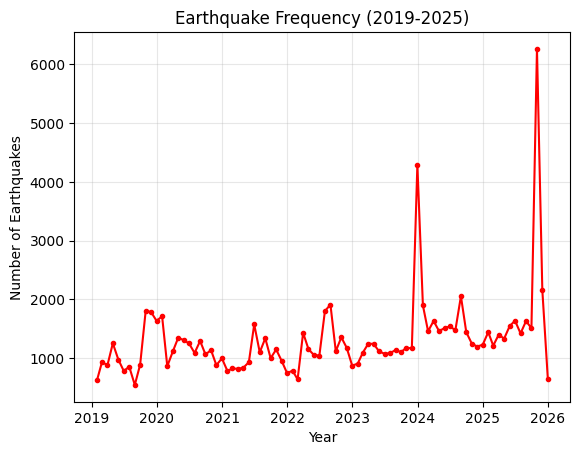

In [41]:
# Resample data by Month ('M') to see the volume over time
monthly_counts = df.set_index('Date_Time_PH').resample('M').size()
plt.plot(monthly_counts.index, monthly_counts.values, color='red', marker='o', markersize=3)
plt.title('Earthquake Frequency (2019-2025)')
plt.ylabel('Number of Earthquakes')
plt.xlabel('Year')
plt.grid(True, alpha=0.3)

### 1. Dropping rows with missing values

In [20]:
df.isnull().sum()

Date_Time_PH          0
Latitude             24
Longitude            24
Depth_In_Km           1
Magnitude             0
Location              0
Specific_Location     0
General_Location      0
dtype: int64

In [23]:
df = df.dropna()

In [24]:
df.isnull().sum()

Date_Time_PH         0
Latitude             0
Longitude            0
Depth_In_Km          0
Magnitude            0
Location             0
Specific_Location    0
General_Location     0
dtype: int64

### 2. Limiting data from 2019 to 2025

In [25]:
df['Date_Time_PH'] = pd.to_datetime(df['Date_Time_PH'])

'''
    Filtering dataset from 2019 to 2025
'''
start_date = '2019-01-01'
end_date = '2025-12-31' 
df = df[(df['Date_Time_PH'] >= start_date) & (df['Date_Time_PH'] <= end_date)]

print(f"Dataset filtered (2019-2025). New row count: {len(df)}")

Dataset filtered (2019-2025). New row count: 110350


/var/folders/k4/7yxy_0xn1fx_1lbbp0f1jv800000gn/T/ipykernel_76140/2124544897.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date_Time_PH'] = pd.to_datetime(df['Date_Time_PH'])


### 3. Turn the date in Philippine time to Time in Day

In [ ]:
# Date_Time_PH -> Time of Day
df['Date_Time_PH'] = pd.to_datetime(df['Date_Time_PH'])
df['Hour'] = df['Date_Time_PH'].dt.hour

def get_time_of_day(h):
    if 0 <= h < 6: return 'Time_Night'
    elif 6 <= h < 12: return 'Time_Morning'
    elif 12 <= h < 18: return 'Time_Afternoon'
    else: return 'Time_Evening'

df['Time_Bin'] = df['Hour'].apply(get_time_of_day)

### 4. Binning magnitude to categories (e.g., micro, minor, light, etc.)

In [27]:
'''
    Binning numerical data to categorical data
'''
# Magnitude -> Category
bins_mag = [0, 3, 4, 5, 6, 7, 10]
labels_mag = ['Magnitude_Micro', 'Magnitude_Minor', 'Magnitude_Light', 'Magnitude_Moderate', 'Magnitude_Strong', 'Magnitude_Major']
df['Magnitude_Bin'] = pd.cut(df['Magnitude'], bins=bins_mag, labels=labels_mag)


### 5. Binning depth to categories

In [ ]:
'''
    Binning numerical data to categorical data. Convert Depth_In_Km first from object to int.
'''
# 1. Coerce errors to NaN
df["Depth_In_Km"] = pd.to_numeric(df["Depth_In_Km"], errors='coerce')

# 2. Drop rows where Depth is NaN
df = df.dropna(subset=["Depth_In_Km"])

# 3. Convert to integer
df["Depth_In_Km"] = df["Depth_In_Km"].astype('int64')

bins_depth = [0, 70, 300, 1000]
labels_depth = ['Depth_Shallow', 'Depth_Intermediate', 'Depth_Deep']
df['Depth_Bin'] = pd.cut(df['Depth_In_Km'], bins=bins_depth, labels=labels_depth)

### 6. Handling location bin

In [43]:
# D. Location (Using General_Location)
# We make it uppercase and remove whitespace to avoid "Davao " vs "Davao" mismatch
df['Location_Bin'] = df['General_Location'].str.upper().str.strip()

### 7. Create final basket for Apriori

In [45]:
# --- FINAL BASKET CREATION ---
# Create the transaction dataset with just the categorical columns
transactions = df[['Location_Bin', 'Time_Bin', 'Magnitude_Bin', 'Depth_Bin']].astype(str)

print("\nSample Transaction Data for Apriori:")
print(transactions.head())


Sample Transaction Data for Apriori:
         Location_Bin      Time_Bin    Magnitude_Bin           Depth_Bin
0      DAVAO ORIENTAL  Time_Morning  Magnitude_Minor       Depth_Shallow
1            SORSOGON  Time_Morning  Magnitude_Micro       Depth_Shallow
2      DAVAO ORIENTAL  Time_Morning  Magnitude_Light       Depth_Shallow
3                CEBU  Time_Morning  Magnitude_Micro       Depth_Shallow
4  OCCIDENTAL MINDORO  Time_Morning  Magnitude_Micro  Depth_Intermediate


## Exploratory Data Analysis